# Pegasos SVM implementations from scratch

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.datasets.samples_generator import make_blobs

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pegasos algorithm

### Make synthetic dataset

We will make a synthetic dataset using scikit-learn to ensure we have a decent dataset to work with. SVMs is about finding the best hyperplane that separates data. We see below that there are a possible hyperplanes - but how do we find the best hyperplane. We need to find the best hyperplane such that we maximise the margins.

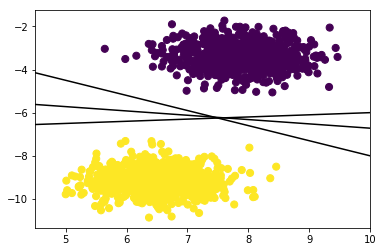

In [33]:
X, y = make_blobs(
    n_samples=1500,
    centers=2,
    random_state=6,
    cluster_std=0.6
)
y = y[:, None]
plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), s=50);

xfit = np.linspace(4.5, 10)

for m, b in [(-0.7, -1), (-0.2, -4.72), (0.1, -7)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(4.5, 10);

### Setup

We set up our loss function, and initialize our parameters. There are many different ways to optimize SVMs such as primal/dual optimization. These can be solved using quadtratic programming methods. However, we can also use gradient descent to solve this. Typically we have a loss function that is not differential in Hinge Loss. But we can turn this problem into a sub-gradient descent and solve using gradient descent.

In [34]:
X = np.hstack([X, np.ones((X.shape[0], 1))])

In [35]:
y = np.where(y == 0, -1, y)

Split into train test set

In [36]:
train_idxs = np.random.choice(X.shape[0], 1000)
test_idxs = np.setdiff1d(np.arange(X.shape[0]), train_idxs)
X_tr = X[train_idxs]
y_tr = y[train_idxs]
X_te = X[test_idxs]
y_te = y[test_idxs]

Helper functions

In [37]:
def predict(X, w):
    return np.dot(X, w)

def svm_preds(y_preds):
    return np.where(y_preds >= 0, 1, -1)

def accuracy(y, y_preds):
    return (y == y_preds).sum() / y.shape[0]

### Train binary SVM

Using SGD

In [117]:
sv = np.zeros((X_tr.shape[0], 1))

In [118]:
sv.shape

(1000, 1)

In [120]:
sv[[684]]

array([[0.]])

In [153]:
n_samples = X_tr.shape[0]
w = np.zeros((X_tr.shape[1],1)) # n_features x n_classes
batch_size = 1
lam = 0.01
losses = []
train_accs = []
test_accs = []
epochs = 100
for epoch in range(1, epochs+1):
    # Select random batch
    batch_idxs = np.random.choice(n_samples, batch_size, replace=False)
    X_s = X_tr[batch_idxs]
    y_s = y_tr[batch_idxs]
    lr = 1 / (lam * epoch)
    # Predict
    score = predict(X_s, w)
    # Calculate loss
    loss = np.maximum(0, 1 - y_s * score)
    if loss > 0:
        sv[batch_idxs] = sv[batch_idxs] + 1
    train_preds = svm_preds(predict(X_tr, w))
    train_acc = accuracy(y_tr, train_preds)
    test_preds = svm_preds(predict(X_te, w))
    test_acc = accuracy(y_te, test_preds)
    # Calculate gradient
    dW = 0 if loss == 0 else (y_s * X_s).T
    # Update rule
    w = ((1 - (lr * lam)) * w) + lr * dW
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    if epoch % 10 == 0:
        print(f"epoch={epoch}/{epochs}, train_acc={train_acc:.4f}, test_acc={test_acc:.4f}")
    losses.append(loss.flatten())

epoch=10/100, train_acc=0.9870, test_acc=0.9802
epoch=20/100, train_acc=0.9870, test_acc=0.9802
epoch=30/100, train_acc=1.0000, test_acc=1.0000
epoch=40/100, train_acc=1.0000, test_acc=1.0000
epoch=50/100, train_acc=1.0000, test_acc=1.0000
epoch=60/100, train_acc=1.0000, test_acc=1.0000
epoch=70/100, train_acc=1.0000, test_acc=1.0000
epoch=80/100, train_acc=1.0000, test_acc=1.0000
epoch=90/100, train_acc=1.0000, test_acc=1.0000
epoch=100/100, train_acc=1.0000, test_acc=1.0000


In [154]:
s = predict(X_tr, w)
# Calculate loss
loss = np.maximum(0, 1 - y_s * s)

In [155]:
(loss > 0).sum()

503

In [132]:
X_tr.shape

(1000, 3)

In [133]:
X_tr[sv.flatten() > 0]

array([[ 7.34970937, -3.87003518,  1.        ],
       [ 5.90707604, -8.61072172,  1.        ],
       [ 7.40333827, -3.70637503,  1.        ],
       [ 7.24187099, -8.18912758,  1.        ],
       [ 7.53752882, -3.91558535,  1.        ],
       [ 8.50201389, -3.95375025,  1.        ],
       [ 7.80670042, -3.62954331,  1.        ],
       [ 7.7994792 , -3.87821766,  1.        ],
       [ 7.340778  , -4.30885739,  1.        ],
       [ 5.83359139, -9.396005  ,  1.        ],
       [ 7.42336239, -9.88585759,  1.        ],
       [ 7.35614538, -3.34308492,  1.        ],
       [ 7.86425467, -2.01700898,  1.        ],
       [ 6.59182765, -9.62993405,  1.        ],
       [ 6.73947156, -9.00731294,  1.        ],
       [ 5.50684675, -7.8943714 ,  1.        ]])

In [39]:
train_preds = svm_preds(predict(X_tr, w))
test_preds = svm_preds(predict(X_te, w))

In [40]:
print(accuracy(y_tr, train_preds))
print(accuracy(y_te, test_preds))

1.0
1.0


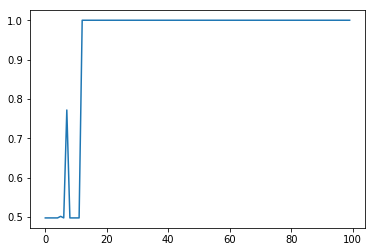

In [41]:
plt.plot(test_accs)

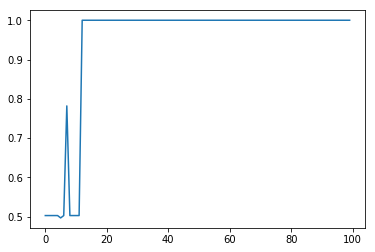

In [42]:
plt.plot(train_accs)

Using Minibatch SGD

In [43]:
def hinge_loss(y, y_pred, w, lam=0.01):
    ind_fn = y * y_pred
    n_b = y.shape[0]
    loss = np.maximum(0, 1 - ind_fn)
    loss = (loss.sum() / n_b) + (0.5 * lam * np.sum(w * w))
    return loss, ind_fn

In [44]:
n_samples = X_tr.shape[0]
w = np.zeros((X_tr.shape[1],1)) # n_features x n_classes
batch_size = 32
lam = 0.01
train_loss_history = []
test_loss_history = []
train_accs = []
test_accs = []
epochs = 100
for epoch in range(1, epochs+1):
    # Select random batch
    batch_idxs = np.random.choice(n_samples, batch_size, replace=False)
    X_s = X_tr[batch_idxs]
    y_s = y_tr[batch_idxs]
    lr = 1 / (lam * epoch)
    # Predict
    score = predict(X_s, w)
    # Calculate loss
    # ind_fn = y_s * score
    n_b = X_s.shape[0]
    # loss = np.maximum(0, 1 - ind_fn)
    # loss = loss.sum() / n_b + 0.5 * lam * np.sum(w * w)
    loss, ind_fn = hinge_loss(y_s, score, w, lam=lam)
    test_loss, _ = hinge_loss(y_te, predict(X_te, w), w, lam=lam)
    # Calculate accuracy
    train_preds = svm_preds(predict(X_tr, w))
    train_acc = accuracy(y_tr, train_preds)
    test_preds = svm_preds(predict(X_te, w))
    test_acc = accuracy(y_te, test_preds)
    # The set that meets the indicator function criteria
    mask = np.zeros_like(ind_fn)
    mask[ind_fn < 1] = 1
    # Calculate gradient
    dW = np.dot((y_s * X_s).T, mask) / n_b
    # Update rule
    w = ((1 - (lr * lam)) * w) + lr * dW
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_loss_history.append(loss)
    test_loss_history.append(test_loss)
    if epoch % 1 == 0:
        print(f"epoch={epoch}/{epochs}, train_loss={loss:.4f}, test_loss={test_loss}, "
              f"train_acc={train_acc:.4f}, test_acc={test_acc:.4f}"
        )
    losses.append(loss.flatten())

epoch=1/100, train_loss=1.0000, test_loss=1.0, train_acc=0.5030, test_acc=0.4980
epoch=2/100, train_loss=1563.0947, test_loss=1377.7015347901718, train_acc=0.5030, test_acc=0.4980
epoch=3/100, train_loss=656.9477, test_loss=773.4787758452081, train_acc=0.4970, test_acc=0.5020
epoch=4/100, train_loss=169.5533, test_loss=174.640994286325, train_acc=0.9200, test_acc=0.9078
epoch=5/100, train_loss=100.6308, test_loss=99.2128893508719, train_acc=0.9200, test_acc=0.9078
epoch=6/100, train_loss=62.6310, test_loss=62.631036657612114, train_acc=1.0000, test_acc=1.0000
epoch=7/100, train_loss=43.4938, test_loss=43.493775456675074, train_acc=1.0000, test_acc=1.0000
epoch=8/100, train_loss=31.9546, test_loss=31.954610539598022, train_acc=1.0000, test_acc=1.0000
epoch=9/100, train_loss=24.4652, test_loss=24.465248694379735, train_acc=1.0000, test_acc=1.0000
epoch=10/100, train_loss=19.3306, test_loss=19.33056686963337, train_acc=1.0000, test_acc=1.0000
epoch=11/100, train_loss=15.6578, test_loss=15

Loss evaluation

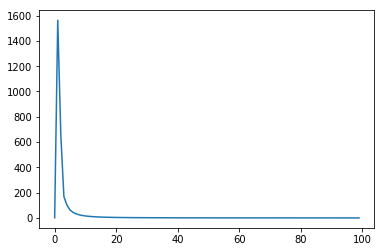

In [45]:
plt.plot(train_loss_history)

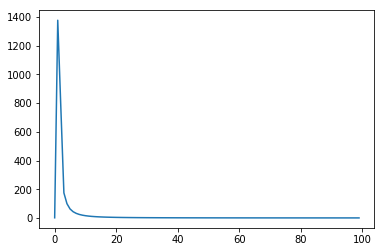

In [46]:
plt.plot(test_loss_history)

Accuracy

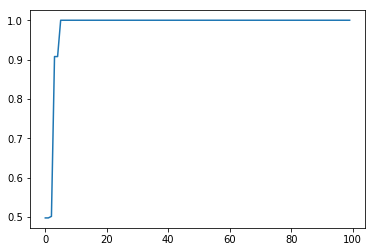

In [47]:
plt.plot(test_accs)

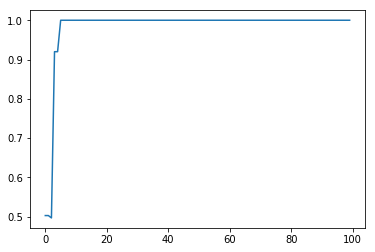

In [48]:
plt.plot(train_accs)

In [134]:
from sklearn.svm import SVC

In [143]:
svc = SVC(kernel="linear")

In [144]:
svc.fit(X_tr, y_tr.flatten())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [145]:
svc.support_vectors_

array([[ 6.98724627, -4.98456237,  1.        ],
       [ 6.41038006, -7.32035884,  1.        ]])

In [138]:
np.argwhere((X_tr == svc.support_vectors_[0]).all(axis=1))

array([[725]])

In [139]:
np.argwhere((X_tr == svc.support_vectors_[1]).all(axis=1))

array([[107]])

In [140]:
svc.support_vectors_

array([[ 6.98724627, -4.98456237,  1.        ],
       [ 6.41038006, -7.32035884,  1.        ]])

In [87]:
X_tr[[725, 107]]

array([[ 6.98724627, -4.98456237,  1.        ],
       [ 6.41038006, -7.32035884,  1.        ]])